#### Loading Data

In [ ]:
from pyspark.sql import SparkSession
from google.colab import drive
from datetime import datetime, timedelta
from os.path import join
import os
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp, date_format, avg

In [ ]:
spark = (SparkSession.builder
         .appName("FinalProject")
         .config("spark.driver.memory", "50g")
         .config("spark.executor.memory", "50g")
         .getOrCreate())

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading Pricing Data
base_path = "/content/drive/MyDrive/Project 4/Pricing"
start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 12, 31)
dataframes = []
current_date = start_date
while current_date <= end_date:
    folder_name = current_date.strftime("%Y%m01realtime_zone_csv")
    file_name = current_date.strftime("%Y%m%drealtime_zone.csv")
    file_path = join(base_path, folder_name, file_name)
    if os.path.exists(file_path):
        try:
            df = spark.read.csv(file_path, header=True, inferSchema=True)
            dataframes.append(df)
            print(f"Loaded file: {file_path}")
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
    else:
        print(f"File does not exist: {file_path}")  # This line adds an indented block under 'else'
    current_date += timedelta(days=1)  # This line increments the date
if dataframes:
    pricing_df = dataframes[0]
    for df in dataframes[1:]:
        pricing_df = pricing_df.union(df)
    pricing_df.show()
else:
    print("No files were loaded.")

Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170101realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170102realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170103realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170104realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170105realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170106realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170107realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170108realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/Pricing/20170101realtime_zone_csv/20170109realtime_zone.csv
Loaded file: /content/drive/MyDrive/Project 4/

In [ ]:
# Loading Load Data
base_path = "/content/drive/MyDrive/Project 4/Loads"
start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 12, 31)
dataframes = []
current_date = start_date
while current_date <= end_date:
    folder_name = current_date.strftime("%Y%m01pal_csv")
    file_name = current_date.strftime("%Y%m%dpal.csv")
    file_path = join(base_path, folder_name, file_name)
    if os.path.exists(file_path):
        try:
            df = spark.read.csv(file_path, header=True, inferSchema=True)
            dataframes.append(df)
            print(f"Loaded file: {file_path}")
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
    else:
        print(f"File does not exist: {file_path}")
    current_date += timedelta(days=1)
if dataframes:
    loads_df = dataframes[0]
    for df in dataframes[1:]:
        loads_df = loads_df.union(df)
    loads_df.show()
else:
    print("No files were loaded.")

Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170101pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170102pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170103pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170104pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170105pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170106pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170107pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170108pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170109pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170110pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170111pal.csv
Loaded file: /content/drive/MyDrive/Project 4/Loads/20170101pal_csv/20170112

In [ ]:
# Datetime Conversion
price_df = pricing_df.withColumn("formatted_timestamp", date_format(to_timestamp("Time Stamp", "MM/dd/yyyy HH:mm:ss"), "yyyy-MM-dd HH:00:00"))
load_df = loads_df.withColumn("formatted_timestamp", date_format(to_timestamp("Time Stamp", "MM/dd/yyyy HH:mm:ss"), "yyyy-MM-dd HH:00:00"))
price_hourly = price_df.groupBy("formatted_timestamp", "PTID").agg(
    avg("LBMP ($/MWHr)").alias("LBMP"),
    avg("Marginal Cost Losses ($/MWHr)").alias("marginal_cost_losses"),
    avg("Marginal Cost Congestion ($/MWHr)").alias("marginal_cost_congestion"))
price_hourly.show()

+-------------------+-----+------------------+--------------------+------------------------+
|formatted_timestamp| PTID|              LBMP|marginal_cost_losses|marginal_cost_congestion|
+-------------------+-----+------------------+--------------------+------------------------+
|2017-01-01 13:00:00|61761|16.276666666666664|               1.415|                     0.0|
|2017-01-01 01:00:00|61753|0.9866666666666664| 0.08749999999999998|      -3.896666666666667|
|2017-01-01 20:00:00|61762| 31.96333333333334|  3.4999999999999996|                 -3.3425|
|2017-01-01 10:00:00|61753|13.179166666666667|-0.27499999999999997|     -0.8333333333333334|
|2017-01-01 16:00:00|61756|           15.9825|  0.5491666666666667|     -0.7208333333333332|
|2017-01-01 09:00:00|61758|           26.3425|  0.7866666666666666|                -16.3675|
|2017-01-01 11:00:00|61759| 17.31083333333333| 0.45249999999999996|     -11.851666666666667|
|2017-01-01 23:00:00|61846|14.104166666666666| -1.1000000000000003|   

In [ ]:
# Merging Data
pricing_selected = price_hourly.select("PTID", "formatted_timestamp", "LBMP", "marginal_cost_losses", "marginal_cost_congestion")
loads_selected = load_df.select("PTID", "formatted_timestamp", "load")
merged_df = pricing_selected.join(loads_selected, on=["PTID", "formatted_timestamp"], how="inner")
reordered_df = merged_df.select("PTID", "formatted_timestamp", "LBMP","marginal_cost_losses", "marginal_cost_congestion", "load")
reordered_df.show()

+-----+-------------------+------------------+--------------------+------------------------+------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load|
+-----+-------------------+------------------+--------------------+------------------------+------+
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1671.9|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1667.5|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1613.6|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1629.4|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1639.3|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1631.3|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1638.7|


In [ ]:
# Datetime Function Creation
def datetime_conversion(df, col):
    return df.withColumn("_year", F.year(col)) \
             .withColumn("month", F.month(col)) \
             .withColumn("day", F.dayofmonth(col)) \
             .withColumn("hour", F.hour(col))\
             .withColumn("day_of_week", F.dayofweek(col))
final_df = datetime_conversion(reordered_df, "formatted_timestamp")

In [ ]:
# Final df
cleaned_df = final_df.na.drop()
cleaned_df.show()
row_count = cleaned_df.count()
print(f"Total records: {row_count}")

+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load|_year|month|day|hour|day_of_week|
+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1671.9| 2017|    1|  1|   0|          1|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1667.5| 2017|    1|  1|   0|          1|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1613.6| 2017|    1|  1|   0|          1|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1629.4| 2017|    1|  1|   0|          1|
|61754|2017-01-01 00:00:00| 3.382727272727273|-0.00454545454545...|  

In [ ]:
# Parquet file
parquet_path = '/content/drive/MyDrive/Project 4/cleaned_data.parquet'
cleaned_df.write.parquet(parquet_path)
print(f"Data saved to {parquet_path}")

Data saved to /content/drive/MyDrive/Project 4/cleaned_data.parquet


In [ ]:
# Loading Data
path = '/content/drive/MyDrive/Project 4/cleaned_data.parquet'
cleaned_df = spark.read.parquet(path)
cleaned_df.show()

+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load|_year|month|day|hour|day_of_week|
+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.2| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1636.1| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1630.4| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.6| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|  

1. Predict electricity prices (LBMP) based on the historical load demand patterns

In [ ]:
# Importing Functions
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
from pyspark.ml.regression import GBTRegressor

In [ ]:
# Creating q1_df
q1_df = cleaned_df

In [ ]:
# Training and testing data
q1_train_df = q1_df.filter(~F.col("month").isin([3, 6, 9, 12]))
q1_train_df.show(10)
q1_test_df = q1_df.filter(F.col("month").isin([3, 6, 9, 12]))
q1_test_df.show(10)

+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load|_year|month|day|hour|day_of_week|
+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
|61761|2017-01-01 13:00:00|16.276666666666664|               1.415|                     0.0|5145.1| 2017|    1|  1|  13|          1|
|61761|2017-01-01 13:00:00|16.276666666666664|               1.415|                     0.0|5150.3| 2017|    1|  1|  13|          1|
|61761|2017-01-01 13:00:00|16.276666666666664|               1.415|                     0.0|5185.6| 2017|    1|  1|  13|          1|
|61761|2017-01-01 13:00:00|16.276666666666664|               1.415|                     0.0|5173.2| 2017|    1|  1|  13|          1|
|61761|2017-01-01 13:00:00|16.276666666666664|               1.415|  

In [ ]:
# Filtering
q1_train = q1_train_df.select("day","day_of_week", "hour", "Load","LBMP")
q1_test = q1_test_df.select("day","day_of_week", "hour", "Load","LBMP")

In [ ]:
# Feature assembly
feature_columns = ["day", "day_of_week", "hour", "Load"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
q1_train_assembled = assembler.transform(q1_train)
q1_test_assembled = assembler.transform(q1_test)

In [ ]:
# Logistic Regression
lr = LinearRegression(featuresCol="features", labelCol="LBMP")
lr_model = lr.fit(q1_train_assembled)

In [ ]:
# Metrics
predictions = lr_model.transform(q1_test_assembled)
evaluator = RegressionEvaluator(labelCol="LBMP", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R² on the test data: {r2}")

R² on the test data: -0.01098302794895245


In [ ]:
# Creating new features
q1_train = q1_train_df.withColumn("day_of_year", F.dayofyear("formatted_timestamp"))
q1_train = q1_train.withColumn("is_weekend", F.when(F.col("day_of_week").isin([6, 7]), 1).otherwise(0))
q1_train = q1_train.withColumn("hour_sin", F.sin(2 * 3.14159 * F.col("hour") / 24))
q1_train = q1_train.withColumn("hour_cos", F.cos(2 * 3.14159 * F.col("hour") / 24))
q1_train = q1_train.withColumn("week_of_year", F.weekofyear("formatted_timestamp"))
q1_train = q1_train.withColumn("day_of_month", F.dayofmonth("formatted_timestamp"))
q1_train = q1_train.withColumn("hour_day_of_week", F.col("hour") * F.col("day_of_week"))
q1_train = q1_train.withColumn("load_rolling_avg", F.avg("load").over(Window.orderBy("formatted_timestamp").rowsBetween(-5, 0)))
q1_train = q1_train.withColumn("load_lag", F.lag("load", 1).over(Window.orderBy("formatted_timestamp")))
q1_train = q1_train.withColumn("time_of_day", F.col("hour") / 24.0)
q1_train = q1_train.withColumn("cumulative_load", F.sum("load").over(Window.orderBy("formatted_timestamp")))
q1_test = q1_test_df.withColumn("day_of_year", F.dayofyear("formatted_timestamp"))
q1_test = q1_test.withColumn("is_weekend", F.when(F.col("day_of_week").isin([6, 7]), 1).otherwise(0))
q1_test = q1_test.withColumn("hour_sin", F.sin(2 * 3.14159 * F.col("hour") / 24))
q1_test = q1_test.withColumn("hour_cos", F.cos(2 * 3.14159 * F.col("hour") / 24))
q1_test = q1_test.withColumn("week_of_year", F.weekofyear("formatted_timestamp"))
q1_test = q1_test.withColumn("day_of_month", F.dayofmonth("formatted_timestamp"))
q1_test = q1_test.withColumn("hour_day_of_week", F.col("hour") * F.col("day_of_week"))
q1_test = q1_test.withColumn("load_rolling_avg", F.avg("load").over(Window.orderBy("formatted_timestamp").rowsBetween(-5, 0)))
q1_test = q1_test.withColumn("load_lag", F.lag("load", 1).over(Window.orderBy("formatted_timestamp")))
q1_test = q1_test.withColumn("time_of_day", F.col("hour") / 24.0)
q1_test = q1_test.withColumn("cumulative_load", F.sum("load").over(Window.orderBy("formatted_timestamp")))
q1_train = q1_train.na.drop()
q1_test = q1_train.na.drop()
q1_train.show()
q1_test.show()
feature_columns = [
    "day", "day_of_week", "hour", "load", "day_of_year", "is_weekend", "hour_sin", "hour_cos",
    "week_of_year", "day_of_month", "hour_day_of_week", "load_rolling_avg", "load_lag",
    "time_of_day", "cumulative_load"
]

+-----+-------------------+-----------------+--------------------+------------------------+------+-----+-----+---+----+-----------+-----------+----------+--------+--------+------------+------------+----------------+------------------+--------+-----------+---------------+
| PTID|formatted_timestamp|             LBMP|marginal_cost_losses|marginal_cost_congestion|  load|_year|month|day|hour|day_of_week|day_of_year|is_weekend|hour_sin|hour_cos|week_of_year|day_of_month|hour_day_of_week|  load_rolling_avg|load_lag|time_of_day|cumulative_load|
+-----+-------------------+-----------------+--------------------+------------------------+------+-----+-----+---+----+-----------+-----------+----------+--------+--------+------------+------------+----------------+------------------+--------+-----------+---------------+
|61754|2017-01-01 00:00:00|3.382727272727273|-0.00454545454545...|     -5.0645454545454545|1667.5| 2017|    1|  1|   0|          1|          1|         0|     0.0|     1.0|          52

In [ ]:
# PCA
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
q1_train_assembled = assembler.transform(q1_train)
q1_test_assembled = assembler.transform(q1_test)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(q1_train_assembled)
q1_train_scaled = scaler_model.transform(q1_train_assembled)
q1_test_scaled = scaler_model.transform(q1_test_assembled)
pca = PCA(k=10, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(q1_train_scaled)
explained_variance = pca_model.explainedVariance
eigenvalues = explained_variance.values
num_components = sum(eigenvalues > 0.1)
if num_components == 0:
    num_components = 5
pca = PCA(k=num_components, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(q1_train_scaled)
q1_train_pca = pca_model.transform(q1_train_scaled)
q1_test_pca = pca_model.transform(q1_test_scaled)
print(f"Explained Variance: {explained_variance}")
print(f"Eigenvalues: {eigenvalues}")

Explained Variance: [0.2333523410046664,0.19932708146903994,0.17613393628358556,0.13263453254166743,0.13003783222022583,0.0661327344903827,0.02129769543742924,0.016141522062740065,0.010889214609146406,0.005952340328408562]
Eigenvalues: [0.23335234 0.19932708 0.17613394 0.13263453 0.13003783 0.06613273
 0.0212977  0.01614152 0.01088921 0.00595234]


In [ ]:
# Initialize the GBT Regressor with specific hyperparameters
gbt = GBTRegressor(featuresCol="features", labelCol="LBMP", maxIter=100, maxDepth=10, stepSize=0.1)
gbt_model = gbt.fit(q1_train_pca)

In [ ]:
# Metrics
predictions = gbt_model.transform(q1_test_pca)
evaluator = RegressionEvaluator(labelCol="LBMP", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R² on the test data: {r2}")

R² on the test data: 0.9390490951715208


I improved the accuracy of predicting electricity prices (LBMP) by enhancing the data and using a better model. I created new features, like rolling averages, lag values, and time-based transformations (e.g., sine and cosine for hours), to capture patterns in the data. I standardized the features and used Principal Component Analysis (PCA) to reduce complexity. Switching to a Gradient Boosted Trees (GBT) regressor helped capture non-linear relationships. These steps, combined with careful tuning of the model, boosted the R² score to 0.939, showing a significant improvement in accuracy.

#### 2) Detect unusual price spikes in electricity prices (LBMP) due to sudden changes in demand or grid conditions, such as congestion or losses

In [ ]:
# Import Functions
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lag, avg, expr
from pyspark.sql.window import Window
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Selecting Features
q2_df = cleaned_df
q2_df = q2_df.select("PTID", "formatted_timestamp", "LBMP", "marginal_cost_losses", "marginal_cost_congestion", "load")
q2_df.show()

+-----+-------------------+------------------+--------------------+------------------------+------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load|
+-----+-------------------+------------------+--------------------+------------------------+------+
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.2|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1636.1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1630.4|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.6|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1622.3|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1608.6|


In [ ]:
# New Features
q2_df = q2_df.withColumn("price_to_load_ratio", col("LBMP") / col("load"))
window_spec = Window.partitionBy().orderBy("formatted_timestamp")
q2_df = q2_df.withColumn("LBMP_moving_avg", avg("LBMP").over(window_spec.rowsBetween(-2, 0)))
q2_df = q2_df.withColumn("LBMP_diff", col("LBMP") - lag("LBMP", 1).over(window_spec))
q2_df = q2_df.na.drop()
q2_df.show()

+-----+-------------------+------------------+--------------------+------------------------+------+--------------------+------------------+-------------------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load| price_to_load_ratio|   LBMP_moving_avg|          LBMP_diff|
+-----+-------------------+------------------+--------------------+------------------------+------+--------------------+------------------+-------------------+
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1636.1|0.002139789188258...|3.5009090909090905|                0.0|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1630.4|0.002147270050851994|3.5009090909090905|                0.0|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.6|0.002140443317992841|3.5009090909090905|                0.0|
|61752|2017-01-01 00:00:00|3.50090909090

In [ ]:
# Convert DataFrame to pandas
q2_df_pandas = q2_df.select("LBMP", "marginal_cost_losses", "marginal_cost_congestion",
                         "load", "price_to_load_ratio", "LBMP_moving_avg", "LBMP_diff").toPandas()
scaler = StandardScaler()
q2_df_pandas_scaled = scaler.fit_transform(q2_df_pandas)

In [ ]:
# Batch DBscan
batch_size = 100000
batches = [q2_df_pandas.iloc[i:i + batch_size] for i in range(0, len(q2_df_pandas), batch_size)]
cluster_results = []
for batch in batches:
    batch_scaled = scaler.fit_transform(batch)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    batch.loc[:, 'cluster'] = dbscan.fit_predict(batch_scaled)
    cluster_results.append(batch)

q2_df_pandas_with_clusters = pd.concat(cluster_results)

<ipython-input-10-7027537219ca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.loc[:, 'cluster'] = dbscan.fit_predict(batch_scaled)  # Use .loc[] to avoid SettingWithCopyWarning
<ipython-input-10-7027537219ca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.loc[:, 'cluster'] = dbscan.fit_predict(batch_scaled)  # Use .loc[] to avoid SettingWithCopyWarning
<ipython-input-10-7027537219ca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

               LBMP  marginal_cost_losses  marginal_cost_congestion    load  \
23        32.970000             -0.154545                -34.801818   320.6   
83        47.657273             -0.105455                -49.437273  1211.6   
95        32.560909             -0.148182                -34.384545  1012.3   
227       46.075000             -0.188333                -49.265000  1166.3   
239       30.737500             -0.276667                -34.015000  4956.1   
...             ...                   ...                       ...     ...   
1088911   25.700000              0.190714                  0.000000   679.6   
1088939  141.183571              2.040000               -113.636429  1375.0   
1088967   41.785714             -2.345000                -18.622143  1960.6   
1089009  179.395714              2.114286               -151.771429  1690.3   
1089023  142.951429              2.160000               -115.279286   417.0   

         price_to_load_ratio  LBMP_moving_avg   LBM

<ipython-input-10-7027537219ca>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch.loc[:, 'cluster'] = dbscan.fit_predict(batch_scaled)  # Use .loc[] to avoid SettingWithCopyWarning


In [ ]:
# Checking Results
noise_points = q2_df_pandas_with_clusters[q2_df_pandas_with_clusters['cluster'] == -1]
num_spikes = len(noise_points)
print(f"Number of unusual price spikes: {num_spikes}")
print("Clusters Dataframe")
print(noise_points)

Number of unusual price spikes: 8685
Clusters Dataframe
               LBMP  marginal_cost_losses  marginal_cost_congestion    load  \
23        32.970000             -0.154545                -34.801818   320.6   
83        47.657273             -0.105455                -49.437273  1211.6   
95        32.560909             -0.148182                -34.384545  1012.3   
227       46.075000             -0.188333                -49.265000  1166.3   
239       30.737500             -0.276667                -34.015000  4956.1   
...             ...                   ...                       ...     ...   
1088911   25.700000              0.190714                  0.000000   679.6   
1088939  141.183571              2.040000               -113.636429  1375.0   
1088967   41.785714             -2.345000                -18.622143  1960.6   
1089009  179.395714              2.114286               -151.771429  1690.3   
1089023  142.951429              2.160000               -115.279286   417.0

In [ ]:
# Adding Timestamp to dataframe
timestamp_df = q2_df.select("formatted_timestamp").toPandas()
q2_df_pandas_with_clusters['formatted_timestamp'] = timestamp_df['formatted_timestamp']
q2_df_pandas_with_clusters.head()

,LBMP,marginal_cost_losses,marginal_cost_congestion,load,price_to_load_ratio,LBMP_moving_avg,LBMP_diff,cluster,formatted_timestamp
0,3.500909,0.103636,-5.075455,1636.1,0.002140,3.500909,0.0,0,2017-01-01 00:00:00
1,3.500909,0.103636,-5.075455,1630.4,0.002147,3.500909,0.0,0,2017-01-01 00:00:00
2,3.500909,0.103636,-5.075455,1635.6,0.002140,3.500909,0.0,0,2017-01-01 00:00:00
3,3.500909,0.103636,-5.075455,1635.1,0.002141,3.500909,0.0,0,2017-01-01 00:00:00
4,3.500909,0.103636,-5.075455,1622.3,0.002158,3.500909,0.0,0,2017-01-01 00:00:00


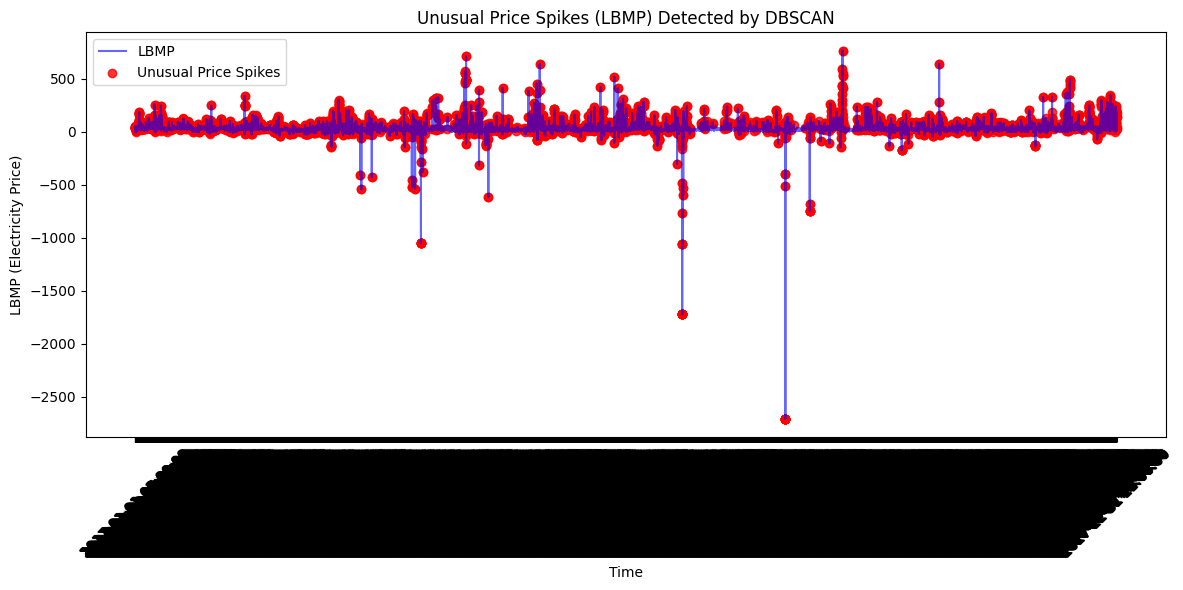

In [ ]:
# Plotting LBMP with spikes highlighted
plt.figure(figsize=(12, 6))
plt.plot(q2_df_pandas_with_clusters['formatted_timestamp'],
         q2_df_pandas_with_clusters['LBMP'], color='blue', label='LBMP', alpha=0.6)
plt.scatter(q2_df_pandas_with_clusters.loc[noise_points.index, 'formatted_timestamp'],
            noise_points['LBMP'], color='red', label='Unusual Price Spikes', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('LBMP (Electricity Price)')
plt.title('Unusual Price Spikes (LBMP) Detected by DBSCAN')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

I identified unusual price spikes in electricity prices (LBMP) by analyzing key factors such as marginal costs, load, and price-to-load ratios. By detecting anomalies in the data, I isolated instances where sudden changes in demand or grid conditions, like congestion or losses, caused significant deviations. Visualizing these spikes over time allowed me to understand when and why these events occurred, providing valuable insights into grid behavior.

#### 3)Forecast future electricity demand (Integrated Load) based on historical electricity prices (LBMP) and grid conditions (marginal costs due to congestion or losses)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt

In [ ]:
q3_df = cleaned_df
q3_df.show()

+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
| PTID|formatted_timestamp|              LBMP|marginal_cost_losses|marginal_cost_congestion|  load|_year|month|day|hour|day_of_week|
+-----+-------------------+------------------+--------------------+------------------------+------+-----+-----+---+----+-----------+
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.2| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1636.1| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1630.4| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|      -5.075454545454544|1635.6| 2017|    1|  1|   0|          1|
|61752|2017-01-01 00:00:00|3.5009090909090905| 0.10363636363636362|  

In [ ]:
# Preparing Data
df = q3_df.toPandas()
df['formatted_timestamp'] = pd.to_datetime(df['formatted_timestamp'])
df = df.sort_values('formatted_timestamp')
hourly_data = df.groupby(['formatted_timestamp']).agg({
    'LBMP': 'mean',
    'marginal_cost_losses': 'mean',
    'marginal_cost_congestion': 'mean',
    'load': 'mean'
}).reset_index()
scaler = MinMaxScaler()
features = hourly_data.drop(['formatted_timestamp'], axis=1)
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_data['formatted_timestamp'] = hourly_data['formatted_timestamp']
def generate_lag_features(data, lags=24):
    X, y = [], []
    for i in range(lags, len(data)):
        X.append(data.iloc[i-lags:i].drop(['formatted_timestamp'], axis=1).values)
        y.append(data.iloc[i]['load'])
    return np.array(X), np.array(y)
lags = 24
X, y = generate_lag_features(scaled_data, lags)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], lags, -1))
X_test = X_test.reshape((X_test.shape[0], lags, -1))

In [ ]:
# Model
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(lags, X_train.shape[2]), recurrent_dropout=0.2)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0.2)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=2
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


204/204 - 12s - 61ms/step - loss: 0.0133 - mae: 0.0816 - val_loss: 0.0029 - val_mae: 0.0457
Epoch 2/50
204/204 - 7s - 36ms/step - loss: 0.0039 - mae: 0.0482 - val_loss: 0.0016 - val_mae: 0.0296
Epoch 3/50
204/204 - 8s - 37ms/step - loss: 0.0027 - mae: 0.0406 - val_loss: 0.0013 - val_mae: 0.0309
Epoch 4/50
204/204 - 7s - 36ms/step - loss: 0.0022 - mae: 0.0364 - val_loss: 9.2111e-04 - val_mae: 0.0250
Epoch 5/50
204/204 - 7s - 36ms/step - loss: 0.0018 - mae: 0.0331 - val_loss: 7.7411e-04 - val_mae: 0.0220
Epoch 6/50
204/204 - 8s - 37ms/step - loss: 0.0016 - mae: 0.0308 - val_loss: 6.2761e-04 - val_mae: 0.0197
Epoch 7/50
204/204 - 7s - 36ms/step - loss: 0.0014 - mae: 0.0287 - val_loss: 5.8876e-04 - val_mae: 0.0181
Epoch 8/50
204/204 - 8s - 37ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 5.7422e-04 - val_mae: 0.0194
Epoch 9/50
204/204 - 7s - 37ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 4.9218e-04 - val_mae: 0.0178
Epoch 10/50
204/204 - 7s - 37ms/step - loss: 0.0012 - mae: 0.0263 - 

In [ ]:
# Metrics
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
R² Score: 0.9905065348932865


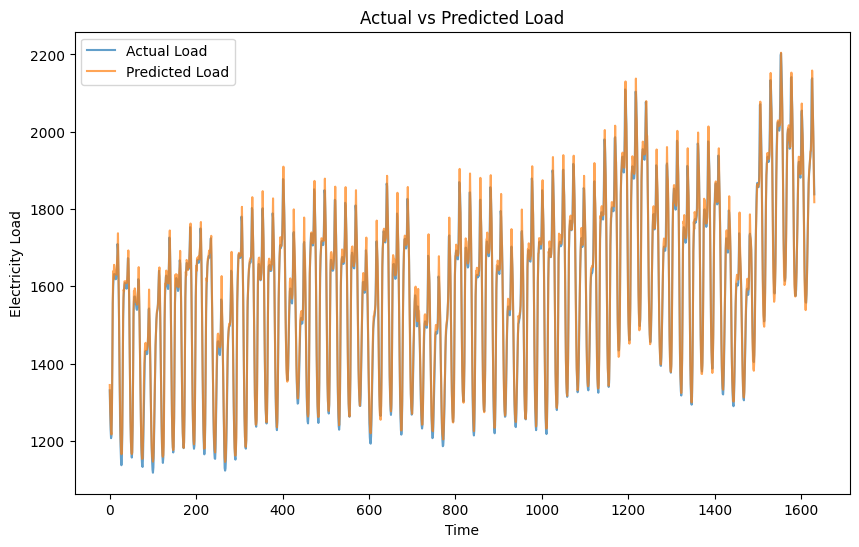

In [ ]:
# Visualization
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((len(y_test), features.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack((np.zeros((len(y_pred), features.shape[1] - 1)), y_pred)))[:, -1]
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Load', alpha=0.7)
plt.plot(y_pred_actual, label='Predicted Load', alpha=0.7)
plt.title('Actual vs Predicted Load')
plt.xlabel('Time')
plt.ylabel('Electricity Load')
plt.legend()
plt.show()

I aimed to forecast future electricity demand using historical data, including electricity prices (LBMP), marginal costs due to congestion, and losses. To achieve this, I processed and aggregated the data on an hourly basis, creating lagged features to capture temporal dependencies. I normalized the data for consistency and trained a bidirectional LSTM model, leveraging its ability to learn long-term patterns. After training, I evaluated the model's performance using R² and visualized the actual vs predicted demand. The high R² score indicated the model's effectiveness in capturing the relationship between historical data and electricity demand.